In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, recall_score
%matplotlib inline
matplotlib.style.use('ggplot')

# PCA = principal component analysis

  * PCA is an example of unsupervized method: we do not use any knowledge of any target variable.
  * Generally speaking it is just an orthogonal projection of $n$-dimensional space to $q$-dimensional space with $n > q$.
  * If $q = 1$, PCA is an ortogonal projection to a line ( = $1$-dimensional space).
  * This line is selected so that the projected data have maximum possible sample variance.
  * PCA **must be applied to centered data**, i.e. each feature data must be cetered so that the mean is zero.

### Getting the idea
  * We first generate two dimensional data $X \in \mathbb{R}^{n,2}$.
  * We center them.
  * We depict the projection for a selected line and compute the resulting (sample) variance.

In [48]:
# generating random data using 2 data sets both generated via 2-dimensional normal distribution
mean1 = [12,-2]
cov1 = np.matrix([[15,8],[8,8]])
n1 = 150
mean2 = [1,-2]
cov2 = np.matrix([[15,8],[8,8]])
n2 = 150
data1 = pd.DataFrame(np.random.multivariate_normal(mean1, cov1, n1))
data2 = pd.DataFrame(np.random.multivariate_normal(mean2, cov2, n2))
data = pd.concat([data1, data2])
data.columns = ['x', 'y']
n = n1 + n2

In [49]:
def plot_data_projections(data, projection):
    #normalize the projection vector
    projection = [coord/math.sqrt((projection[0]**2 + projection[1]**2)) for coord in projection]
    #number of data
    n = data.shape[0]
    # plotting the original data
    ig, axs = plt.subplots(1,2, figsize=(14,7))
    actual_mean = data.mean()
    print('Data mean: ({0:.2f},{1:.2f})'.format(actual_mean[0],actual_mean[1]))
    axs[0].plot(actual_mean[0], actual_mean[1],'ro')
    axs[0].set_title('Original data')
    data.plot.scatter('x', 'y', ax=axs[0])
    
    # centering data (!! important)
    data = data - data.mean()
    actual_mean = data.mean()
    print('Data mean after centering: ({0:.2f},{1:.2f})'.format(actual_mean[0],actual_mean[1]))
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    # plotting the centered data
    data.plot.scatter('x', 'y', ax=axs[1])
    axs[1].set_title('Centered data')
    # plotting the line given by the projection vector
    axs[1].plot([-100*projection[0],100*projection[0]],[-100*projection[1], 100*projection[1]],'g-')
    # getting the orthogonal projections of the data points to the line
    coordinates = [np.dot(data.iloc[i,:], projection) for i in range(n)]
    dots = np.matrix([[coordinates[i]*projection[0], coordinates[i]*projection[1]] for i in range(n)]).T
    # plotting the projections
    axs[1].plot(dots[0], dots[1],'ro')
    # variance of projected data points
    distances = pd.DataFrame([math.sqrt(dots[0,i]**2 + dots[1,i]**2) for i in range(n)])
    #print("Variance of projected data: {0:.2f}".format(distances.var()[0]))
    print("Variance of projected data: {0:.2f}".format(np.array(coordinates).var(ddof = 1)))

Data mean: (6.11,-2.41)
Data mean after centering: (0.00,0.00)
Variance of projected data: 46.90


46.8991280636063

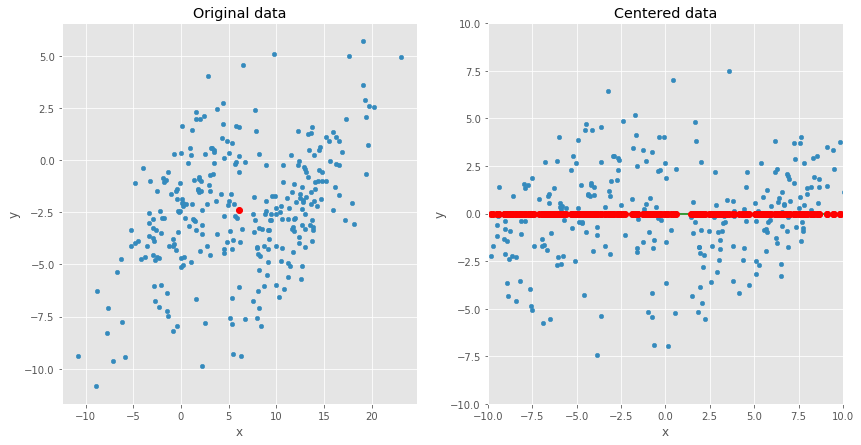

In [50]:
projection = [ 1,0]
plot_data_projections(data, projection)
data.iloc[:, 0].var(ddof = 1)

### Projection line given by the first principal component returned by PCA
  * We use sklearn implementation.
  * Compare the resulting variance of projected data points.

Weights of components (eigenvalues):
[0.87724549 0.12275451]
Weights of components (eigenvalues):
[48.37926465  6.76979612]
Components (eigenvectors):
[[ 0.9820529  0.1886057]
 [-0.1886057  0.9820529]]
Data mean: (6.11,-2.41)
Data mean after centering: (0.00,0.00)
Variance of projected data: 48.38
Data mean: (6.11,-2.41)
Data mean after centering: (0.00,0.00)
Variance of projected data: 6.77


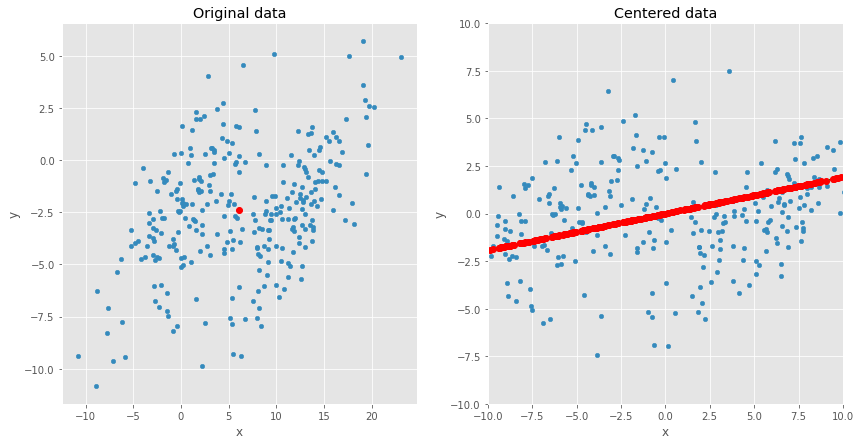

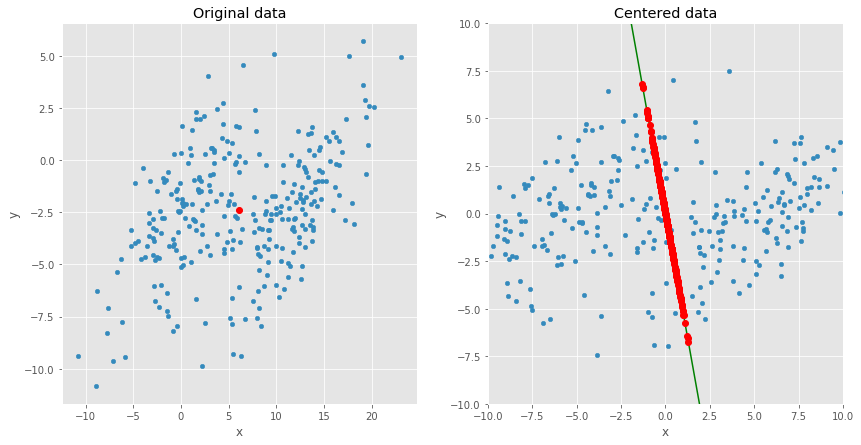

In [51]:
pca = PCA()
pca.fit_transform(data)
print("Weights of components (eigenvalues):")
print(pca.explained_variance_ratio_)
print("Weights of components (eigenvalues):")
print(pca.explained_variance_)
print("Components (eigenvectors):")
print(pca.components_)
plot_data_projections(data, pca.components_[0])
plot_data_projections(data, pca.components_[1])

### Mathematics of PCA (just a hint)

Assume the data are stored in the matrix $X \in \mathbb{R}^{n,p}$ and that thay are centered, meaning that
$$
    \frac{1}{n}\sum^n_i X_{ik} = 0 \quad \text{for all } k = 0,1,2, \ldots, p-1.
$$
Let $w \in \mathbb{R}^p$ be a unit vector defining the line on which we want to project the data points. Using some linear algebra knowledge we can prove that the coordinates of the projection of $i$th data point $x_i = (X_{i0}, \ldots, X_{i(p-1)})$ is the dot product (in Czech "skalární součin") of $x_i$ and $w$ multiplied by the vector $w$, namely $y_i = (x_i, w)w$.
Since the mean of these points is zero
$$
    \frac{1}{n}\sum^n_i y_i = \frac{1}{n}\sum^n_i (x_i, w) w = \left( \frac{1}{n}\sum^n_i x_i, w \right) w = 0
$$
the variance of these points projections is
$$
    \frac{1}{n}\sum^n_i ||y_i||^2 = \frac{1}{n}\sum^n_i (x_i, w)^2 w^Tw = \{ w \text{ is a unit vector} \} = \frac{1}{n}\sum^n_i (x_i, w)^2 = \frac{1}{n}(Xw)^T(Xw) = w^T\frac{X^TX}{n}w.
$$
So, denoting $V = \frac{X^TX}{n}$ (note that it is the covariance matrix of the centered data), we are looking for $w \in \mathbb{R}^p$ such that
$$
    w^TVw \text{ is maximum possible} \quad \text{and} \quad w^Tw = ||w||^2 = 1.
$$

In words, **we are looking for the projection line so that the variance of orthogonally projected points on this line is maximum possible**.

Using the method of Lagrange multipliers for optimisation with constraints (see the MI-MPI course) we get that the maximum value is attained if $w$ is a unit eigenvector of $V$ corresponding to the greatest eigenvalue $\lambda_0$ (all eigenvalues of a positive definite matrix are positive real numbers). Note that then $w^TVw = \lambda$. 

This idea can be applied repetitively (with some details we omit here). All in all, the eigenvectors are called **principal components**, they are known to be mutually orthogonal. The first principal component is the one with the greatest eigenvector, the second principal component is the one with the second greatest eigenvector and so on.



### Using PCA to visualize multidimensional data
  * Data with $p$ features can be understood as set of vectors in $p$-dimensional vecotr space $\mathbb{R}^p$.
  * First two pricipal components given by PCA define a 2-dimensional space a.k.a. a plane.
  * If we project all data points on this plane, we get a 2D chart where the points are "parted" as much as possible.


In [52]:
# generating random data using p-dimensional normal distribution
p = 10
n = 100
mean = np.random.rand(p)*10
A = np.random.rand(p,p)
offset = np.diag(np.full(p, 20))
cov = A.T*A + offset
data = pd.DataFrame(np.random.multivariate_normal(mean, cov, n))
data = data - data.mean()

In [53]:
pca = PCA(n_components=2)
pca.fit_transform(data)
print("Weights of components (eigenvalues):")
print(pca.explained_variance_ratio_)
print("Components (eigenvectors):")
print(pca.components_)

Weights of components (eigenvalues):
[0.17658109 0.13668188]
Components (eigenvectors):
[[-0.06528099  0.22129546 -0.28334255  0.40871088 -0.29195854 -0.25899353
  -0.64348885 -0.05556299 -0.33819734  0.12481629]
 [-0.32655263 -0.38452641  0.58107798 -0.20006021  0.09016034  0.11406781
  -0.3339095  -0.27631619 -0.39845472  0.00862672]]


,PCA1,PCA2
0,-6.121115,2.667651
1,3.145055,6.648581
2,-5.367187,-3.136825
3,1.386629,2.151498
4,2.584747,0.184346


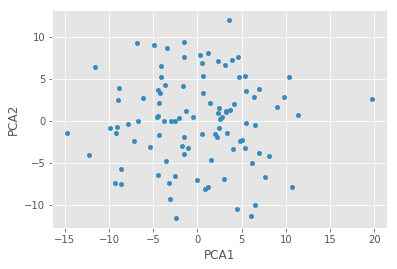

In [54]:
projected_data = pd.DataFrame(pca.transform(data))
projected_data.columns = ['PCA1', 'PCA2']
projected_data.plot.scatter('PCA1', 'PCA2')
projected_data.head()

In [55]:
# just to check that what we have said above
# the projection coordinate of the first data point shoul equal the dot product (w,x_0)
# where w is the corresponding principal component
PCA1 = (np.matrix(pca.components_[0])*np.matrix(data.loc[0,:]).T)[0,0]
PCA2 = (np.matrix(pca.components_[1])*np.matrix(data.loc[0,:]).T)[0,0]
PCA1sklearn = projected_data.iloc[0,0]
PCA2sklearn = projected_data.iloc[0,1]
print("Coordinate of the first data point projection using sklearn: {0:.5f}, {1:.5f}".format(PCA1sklearn, PCA2sklearn))
print("Coordinate of the first data point projection using direct computation: {0:.5f}, {1:.5f}".format(PCA1, PCA2))

Coordinate of the first data point projection using sklearn: -6.12111, 2.66765
Coordinate of the first data point projection using direct computation: -6.12111, 2.66765


### Using PCA as a dimensionality reduction tool
  * For high dimension data with a lot of features we can use the PCA to lower the number of features.
  * More precisely: insted of $p$ features we use their projections to $q < p$ principal component.

In [56]:
# loading and centering
# these are the cleaned data from tutorial 3 with indicator features dropped
data = pd.read_csv('dataForPCA.csv')
data = data.drop([data.columns[0],data.columns[1]], axis=1) # dropping the Id columns
data = data - data.mean()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 64 columns):
MSSubClass          1095 non-null float64
LotFrontage         1095 non-null float64
LotArea             1095 non-null float64
OverallQual         1095 non-null float64
OverallCond         1095 non-null float64
YearBuilt           1095 non-null float64
YearRemodAdd        1095 non-null float64
MasVnrArea          1095 non-null float64
BsmtFinSF1          1095 non-null float64
BsmtFinSF2          1095 non-null float64
BsmtUnfSF           1095 non-null float64
TotalBsmtSF         1095 non-null float64
1stFlrSF            1095 non-null float64
2ndFlrSF            1095 non-null float64
LowQualFinSF        1095 non-null float64
GrLivArea           1095 non-null float64
BsmtFullBath        1095 non-null float64
BsmtHalfBath        1095 non-null float64
FullBath            1095 non-null float64
HalfBath            1095 non-null float64
BedroomAbvGr        1095 non-null float64
KitchenAbvG

### Linear regression without PCA

In [57]:
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=17)
X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtrain.SalePrice
Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
RMSLE_OLS = np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest))
print('Root mean squared logarithmic error:', RMSLE_OLS)

Root mean squared logarithmic error: 0.12754521143963582


### Linear regression with PCA

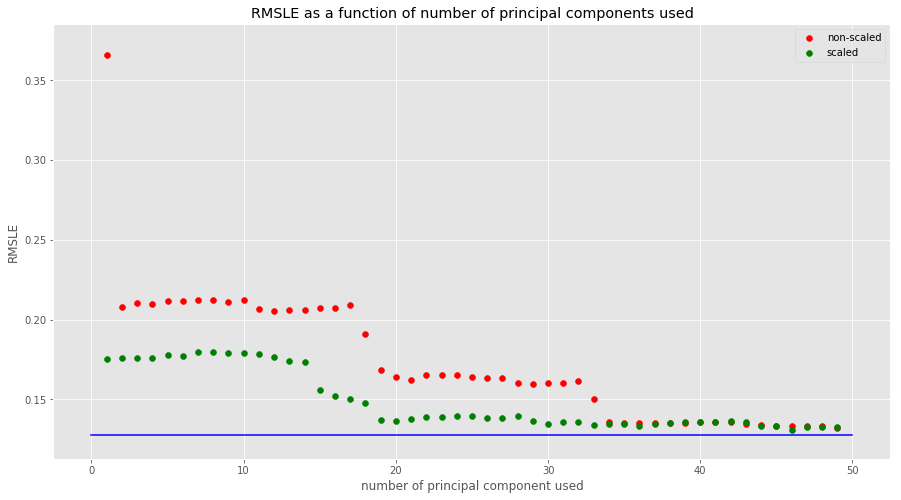

In [58]:
q = 50 # number of components

X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtrain.SalePrice
Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

#### 
# pca with and without scaling
####
pca = PCA()
pca.fit_transform(X)
X1 = pca.transform(X)
Xtest1 = pca.transform(Xtest)

pca.fit_transform(scale(X))
X2 = pca.transform(scale(X))
Xtest2 = pca.transform(scale(Xtest))
RMSLE = []
RMSLE_scale = []
for n in range(1,q):
    Xsub1 = X1[:,0:n]
    Xsubtest1 = Xtest1[:,0:n]
    clf1 = LinearRegression()
    clf1.fit(Xsub1, y) 
    # save RMSLE
    RMSLE.append(np.sqrt(mean_squared_error(clf1.predict(Xsubtest1), ytest)))
    
    Xsub2 = X2[:,0:n]
    Xsubtest2 = Xtest2[:,0:n]
    clf1 = LinearRegression()
    clf1.fit(Xsub2, y) 
    # save RMSLE
    RMSLE_scale.append(np.sqrt(mean_squared_error(clf1.predict(Xsubtest2), ytest)))
plt.subplots(1,1, figsize=(15, 8))
ns = plt.scatter(range(1,q), RMSLE, c='red')
s = plt.scatter(range(1,q), RMSLE_scale, c='green')
plt.title(u"RMSLE as a function of number of principal components used")
plt.xlabel(u'number of principal component used')
plt.ylabel('RMSLE')
plt.plot([0, q], [RMSLE_OLS, RMSLE_OLS],'b-')
plt.legend((ns,s),('non-scaled', 'scaled'))

# LDA = least discriminant analysis

  * It is applicable on **classification data**, i.e. the target variable is cathegorical.
  * It is again a projection to a lower-dimensional subspace.
  * The get the idea assume we project data to a line and that we have two categories:
    * Let $\mu_1$ and $\mu_2$ are means of the projected datapoints of the two catoegories, respectively.
    * Similarly, assume $\sigma^2_1$ and $\sigma^2_2$ are the sample variances of the projected datapoints.
    * The goal of the LDA is to find the line so that the means $\mu_1$ and $\mu_2$ are far away from each other but at the same time the sum of variances $\sigma^2_1 + \sigma^2_2$ is low.
    * Details can be found below, in words we can say that LDA is looking for the projection maximizing **separability** of the data points from distinct categories.

### Projection of 2D data to a line

In [59]:
# generating random data using 2 data sets both generated via 2-dimensional normal distribution
mean1 = [12,-2]
cov1 = np.matrix([[5,4],[4,8]])
n1 = 20
mean2 = [4,-4]
cov2 = np.matrix([[10,4],[4,8]])
n2 = 20
data1 = pd.DataFrame(np.random.multivariate_normal(mean1, cov1, n1))
data1['class'] = np.full(n1,0).T
data2 = pd.DataFrame(np.random.multivariate_normal(mean2, cov2, n2))
data2['class'] = np.full(n2,1).T
data = pd.concat([data1, data2])
data.columns = ['x', 'y','c']
# centering the data for better looking plots
data[['x','y']] = data[['x','y']] - data[['x','y']].mean()
data.head()

,x,y,c
0,6.064620,3.257370,0
1,4.638596,1.753368,0
2,6.312976,3.123548,0
3,5.383127,2.580582,0
4,6.567250,6.658761,0


Cathegories means: 2.51, -2.51
Cathegories sample variances: 8.35, 4.88
Objective function: 1.90


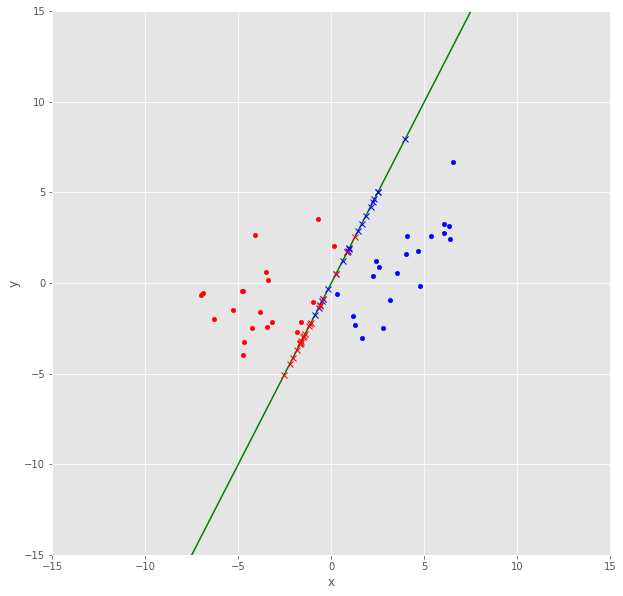

In [60]:
def plot_data_projections(data, projection):
    mean = []
    var = []
    lim = 15
    #normalize the projection vector
    projection = [coord/math.sqrt((projection[0]**2 + projection[1]**2)) for coord in projection]
    #number of data
    n = data.shape[0]
    # plotting the original data
    mean_all = data[['x', 'y']].mean()
    ig, ax = plt.subplots(1,1,figsize=(10, 10))
    data[data['c'] == 1].plot.scatter('x', 'y', c = 'red', ax=ax)
    data[data['c'] == 0].plot.scatter('x', 'y', c = 'blue', ax=ax)
    plt.xlim(mean_all[0]-lim,mean_all[0] + lim)
    plt.ylim(mean_all[1]-lim,mean_all[1] + lim)
    
    ax.plot([-10*lim*projection[0],10*lim*projection[0]],[-10*lim*projection[1], 10*lim*projection[1]],'g-')
    # getting the orthogonal projections of the data points to the line
    colors = ['b','r']
    for k in [0,1]:
        color = colors[k]
        cat = data[data['c'] == k]
        coordinates = [np.dot(cat.iloc[i,0:2], projection) for i in range(cat.shape[0])]
        dots = np.matrix([[coordinates[i]*projection[0], coordinates[i]*projection[1]] for i in range(cat.shape[0])]).T
        # plotting the projections
        ax.plot(dots[0], dots[1], color + 'x')
        # variance of projected data points
        distances = pd.DataFrame(coordinates)
        var.append(distances.var()[0])
        mean.append(distances.mean()[0])
    return mean, var
mean, var = plot_data_projections(data,[1,2])
print("Cathegories means: {0:.2f}, {1:.2f}".format(mean[0], mean[1]))
print("Cathegories sample variances: {0:.2f}, {1:.2f}".format(var[0], var[1]))
objective = (mean[0] - mean[1])**2/(var[0] + var[1])
print("Objective function: {0:.2f}".format(objective))

### Projection line given by LDA
  * We use sklearn implementation.
  * Compare the resulting objective function value of projected data points.

[-2.58622949  0.98639383]
Cathegories means: -3.19, 3.19
Cathegories sample variances: 1.54, 3.06
Objective function: 8.83


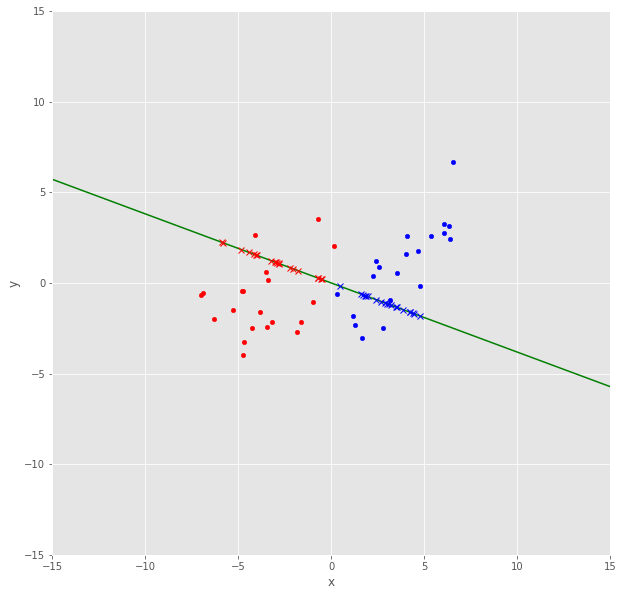

In [62]:
clf = LinearDiscriminantAnalysis(n_components=1,solver='svd', shrinkage=None).fit(data[['x','y']], data['c'])
mean, var = plot_data_projections(data, clf.coef_[0])
print(clf.coef_[0])
print("Cathegories means: {0:.2f}, {1:.2f}".format(mean[0], mean[1]))
print("Cathegories sample variances: {0:.2f}, {1:.2f}".format(var[0], var[1]))
objective = (mean[0] - mean[1])**2/(var[0] + var[1])
print("Objective function: {0:.2f}".format(objective))

### Mathematics of LDA (just a hint)

Assume the data are stored in the matrix $X \in \mathbb{R}^{n,p}$ and that there are $K$ classes (cathegories) of data points. Let us denote $N_c$ the number of points on class $c$. The class is indicated in target variable $Y \in \mathbb{R}^{n,1}$. Let $\mu \in \mathbb{R}^p$ be the mean vector of all data and $\mu_c$ the mean vectors for class $c \in \{1,2, \ldots, K\}$.

We define **scatter matrices** from $\mathbb{R}^{p,p}$
$$
    S_B = \sum_{c = 1}^K N_c (\mu_c - \mu)(\mu_c - \mu)^T
$$
and
$$
    S_W = \sum_{c = 1}^K \sum_{i \in \text{class}_c} (x_i - \mu_c)(x_i - \mu_c)^T
$$
where by $i \in \text{class}_c$ we mean that $i$ is an index of a data point in class $c$.

Let $w \in \mathbb{R}^{p}$ be a vector that define a projection line. Then LDA looks for $w$ that maximize the objective function
$$
    J(w) = \frac{w^T S_B w}{w^T S_W w}.
$$
Again usin the method of Lagrange multipliers for optimisation with constraints we get that the (mutually orthogonal) local extremal values are attained if $w$ is an egenvector of the matrix $S_W^{-1}S_B$. The corresponding eigenvalue $\lambda$ is again the value of the objective function, i.e., $J(w) = \lambda$. Note that the rank of $S_B$ is at most $K - 1$ and hence the maximum number of nonzero eigenvalues is also at most $K - 1$.

### Using LDA to visualize multidimensional data
  * We will use the famous iris data.

(150, 4)
(150, 2)


Text(0, 0.5, 'PCA2')

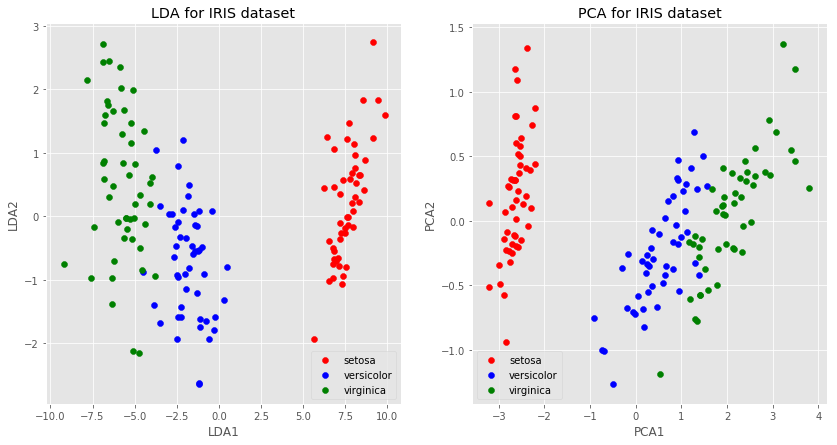

In [63]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
y_names = iris.target_names
# pca
pca = PCA()
pca.fit(X)
Xpca = pca.transform(X)
print(Xpca.shape)
# lda
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
Xlda = lda.transform(X)
print(Xlda.shape)


ig, ax = plt.subplots(1,2,figsize=(14, 7))
colors = ['red', 'blue', 'green']

for i in [0, 1, 2]:
    ax[0].scatter(Xlda[y == i, 0], Xlda[y == i, 1], color=colors[i], label=y_names[i])
ax[0].legend()
ax[0].set_title('LDA for IRIS dataset')
ax[0].set_xlabel('LDA1')
ax[0].set_ylabel('LDA2')

for i in [0, 1, 2]:
    ax[1].scatter(Xpca[y == i, 0], Xpca[y == i, 1], color=colors[i], label=y_names[i])
ax[1].legend()
ax[1].set_title('PCA for IRIS dataset')
ax[1].set_xlabel('PCA1')
ax[1].set_ylabel('PCA2')



### Classification using LDA

In [64]:
# load digits data
digits = datasets.load_digits()
data = pd.DataFrame(digits.data)
data['target'] = digits.target
# print(digits.DESCR)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [65]:
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=17)
X = dtrain.drop(['target'], axis = 1, errors = 'ignore')
y = dtrain.target
Xtest = dtest.drop(['target'], axis = 1, errors = 'ignore')
ytest = dtest.target

# Logistic Regression
clf1 = LogisticRegression()
clf1.fit(X, y) 

# Print RMSLE
recall_logres = recall_score(clf1.predict(Xtest), ytest, average='weighted')
print('Recall for logistic regression: {0:.4f}'.format(recall_logres))

/home/ladislav/MI-PDD2018/cv5/__venv__/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ladislav/MI-PDD2018/cv5/__venv__/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Recall for logistic regression: 0.9511


In [66]:
lda = LinearDiscriminantAnalysis(n_components=50)
Xlda = lda.fit(X, y).transform(X)
lda.predict(Xtest)
recall_lda = recall_score(lda.predict(Xtest), ytest, average='weighted')
print('Recall of LDA: {0:.4f}'.format(recall_lda))
clf1 = LogisticRegression()
clf1.fit(Xlda, y)
recall_logres = recall_score(clf1.predict(lda.transform(Xtest)), ytest, average='weighted')
print('Recall of Logistic regression with LDA: {0:.4f}'.format(recall_logres))

/home/ladislav/MI-PDD2018/cv5/__venv__/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/ladislav/MI-PDD2018/cv5/__venv__/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ladislav/MI-PDD2018/cv5/__venv__/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Recall of LDA: 0.9467
Recall of Logistic regression with LDA: 0.9444


### Task: plot the graph of how LogisticRegression recall depends on n_components parameter